# # P7 Custom BI Project – Payment Method Analysis
#
#  Kevin Hennelly  
#
# This notebook:
# - Loads sales, products, and customers data
# - Creates a unified BI dataset
# - Calculates metrics by Payment Method
# - Performs slicing, dicing, and drilldowns
# - Generates charts for BI

In [2]:
# 1. Imports and Data Loading

import pandas as pd
import matplotlib.pyplot as plt

sales = pd.read_csv("../data/prepared/sales_data_prepared.csv")
products = pd.read_csv("../data/prepared/products_prepared.csv")
customers = pd.read_csv("../data/prepared/customers_prepared.csv")

print("Sales rows:", len(sales))
print("Products rows:", len(products))
print("Customers rows:", len(customers))

display(sales.head())

Sales rows: 1933
Products rows: 98
Customers rows: 200


,TransactionID,SaleDate,CustomerID,ProductID,StoreID,CampaignID,SaleAmount,Quantity,PaymentMethod
0,1,2025-05-04,1034,2059,402,0.0,2048.20,2,Visa
1,2,2025-05-04,1066,2048,403,1.0,321.87,1,Visa
2,3,2025-05-04,1116,2041,403,3.0,3216.84,2,ApplePay
3,4,2025-05-04,1071,2096,404,2.0,1613.23,5,Visa
4,5,2025-05-04,1020,2060,401,0.0,408.38,2,Visa


# ## 2. Create Unified BI Dataset  
# Merge sales → products → customers & add TransactionCount

In [3]:
df = (
    sales.merge(products, on="ProductID", how="left")
         .merge(customers, on="CustomerID", how="left")
)

df["TransactionCount"] = 1

print("Unified dataset rows:", len(df))
display(df.head())

Unified dataset rows: 1933


,TransactionID,SaleDate,CustomerID,ProductID,StoreID,CampaignID,SaleAmount,Quantity,PaymentMethod,ProductName,Category,UnitPrice,StockLevel,Discontinued,Name,Region,JoinDate,LastPurchaseDate,EmailOptIn,TransactionCount
0,1,2025-05-04,1034,2059,402,0.0,2048.20,2,Visa,Electronics-Clear,Home,512.05,121.0,no,Heather Smith,Central,2022-09-16,2024-01-09,no,1
1,2,2025-05-04,1066,2048,403,1.0,321.87,1,Visa,Electronics-Candidate,Home,357.63,82.0,no,Derrick Myers,North,2022-04-06,2024-07-24,yes,1
2,3,2025-05-04,1116,2041,403,3.0,3216.84,2,ApplePay,Home-Assume,Office,804.21,121.0,no,Melissa Rivera,Central,2021-10-25,2025-02-07,no,1
3,4,2025-05-04,1071,2096,404,2.0,1613.23,5,Visa,Office-Discuss,Home,672.18,53.0,no,Christopher Frost,East,2020-08-21,2024-02-11,yes,1
4,5,2025-05-04,1020,2060,401,0.0,408.38,2,Visa,Office-Term,Home,408.38,143.0,no,Michelle Brewer,East,2021-07-14,2021-07-14,no,1


# ## 3. Summary Tables (Payment Method Focus)
# - TotalRevenue  
# - TotalQuantity  
# - TransactionCount  
# - AvgTransactionValue

In [6]:
payment_summary = (
    df.groupby("PaymentMethod")
      .agg(
          TotalRevenue=("SaleAmount", "sum"),
          TotalQuantity=("Quantity", "sum"),
          TransactionCount=("TransactionCount", "count"),
          AvgTransactionValue=("SaleAmount", "mean")
      )
      .reset_index()
)

pm_cat_summary = (
    df.groupby(["PaymentMethod", "Category"])   # FIXED HERE
      .agg(
          Revenue=("SaleAmount", "sum"),
          Quantity=("Quantity", "sum")
      )
      .reset_index()
)

pm_region_summary = (
    df.groupby(["PaymentMethod", "Region"])
      .agg(Revenue=("SaleAmount", "sum"))
      .reset_index()
)

# ## 4. Chart Helper

In [7]:
def bar_chart(x, y, title, xlabel, ylabel, rotation=45):
    plt.figure(figsize=(8, 5))
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# ## 5. Core Charts – Payment Method

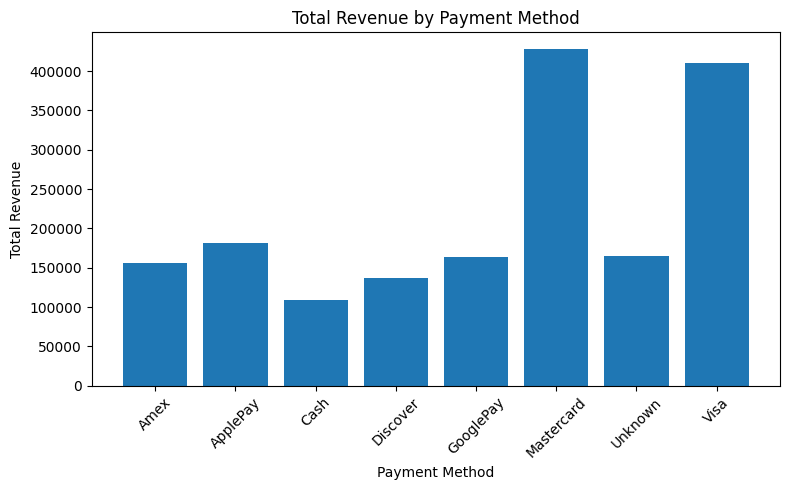

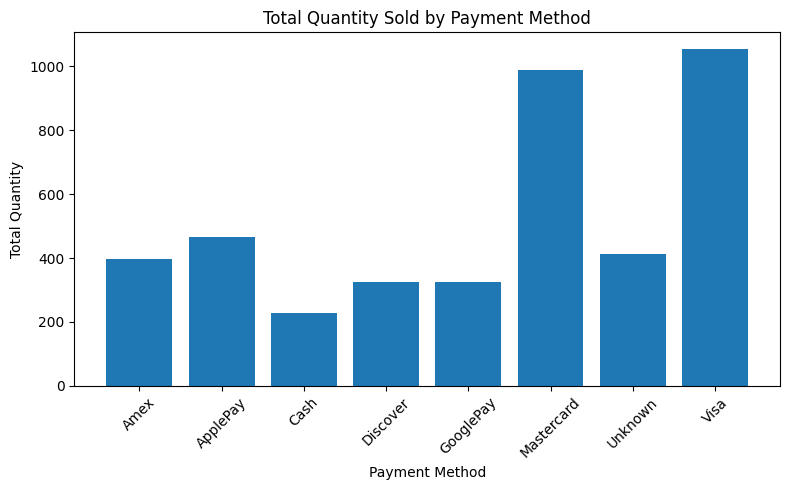

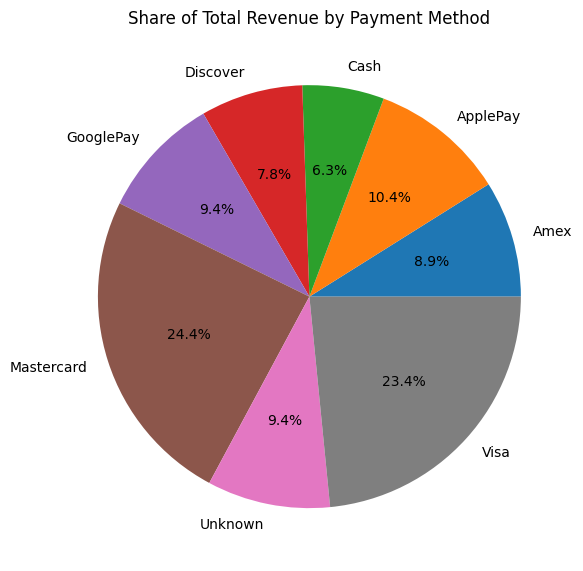

In [8]:
bar_chart(
    payment_summary["PaymentMethod"],
    payment_summary["TotalRevenue"],
    "Total Revenue by Payment Method",
    "Payment Method", "Total Revenue"
)

bar_chart(
    payment_summary["PaymentMethod"],
    payment_summary["TotalQuantity"],
    "Total Quantity Sold by Payment Method",
    "Payment Method", "Total Quantity"
)

plt.figure(figsize=(6, 6))
plt.pie(payment_summary["TotalRevenue"],
        labels=payment_summary["PaymentMethod"],
        autopct="%1.1f%%")
plt.title("Share of Total Revenue by Payment Method")
plt.tight_layout()
plt.show()

# ## 6. Dice: Payment Method × Product Category

=== Pivot: Revenue by Category and Payment Method ===


PaymentMethod,Amex,ApplePay,Cash,Discover,GooglePay,Mastercard,Unknown,Visa
Category,,,,,,,,
Clothing,31877.61,47084.03,14873.14,42304.86,33228.17,98328.90,37371.28,119459.44
Electronics,49772.41,38442.03,24495.59,25816.07,42195.40,95176.60,43737.11,90053.58
Home,41963.43,49361.59,44580.66,35955.49,52308.28,121445.93,45969.30,120373.20
Office,32288.61,46104.52,25506.41,32108.31,36223.73,111891.87,37332.45,80275.71


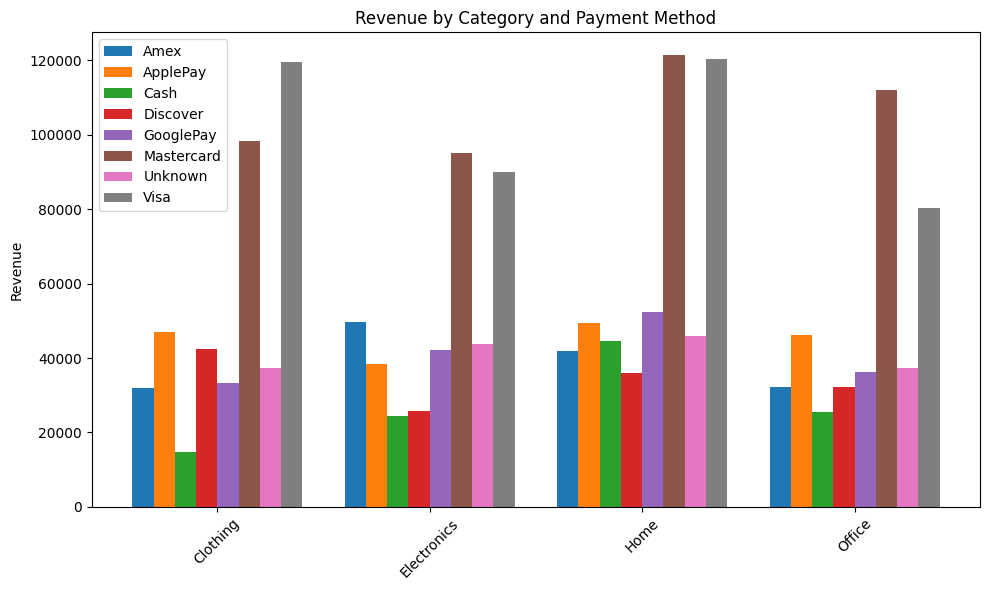

In [ ]:
# %%
pm_cat_pivot = pm_cat_summary.pivot(
    index="Category",
    columns="PaymentMethod",
    values="Revenue"
).fillna(0)

print("=== Pivot: Revenue by Category and Payment Method ===")
display(pm_cat_pivot)

plt.figure(figsize=(10, 6))

categories = pm_cat_pivot.index
methods = pm_cat_pivot.columns
x = range(len(categories))
bar_width = 0.8 / len(methods)

for i, method in enumerate(methods):
    plt.bar(
        [xi + i * bar_width for xi in x],
        pm_cat_pivot[method],
        width=bar_width,
        label=method
    )

plt.xticks(
    [xi + bar_width * (len(methods) - 1) / 2 for xi in x],
    categories,
    rotation=45
)
plt.ylabel("Revenue")
plt.title("Revenue by Category and Payment Method")
plt.legend()
plt.tight_layout()
plt.show()

# ## 7. Slice: Payment Method × Region

PaymentMethod,Amex,ApplePay,Cash,Discover,GooglePay,Mastercard,Unknown,Visa
Region,,,,,,,,
Central,15642.10,19762.53,7792.45,13679.42,14651.73,47152.31,18815.97,35607.83
East,49211.99,49785.26,48269.81,37274.66,62309.08,159738.98,54839.14,140228.79
North,30607.85,37728.94,16122.36,32400.85,41418.09,60128.44,30067.05,87693.08
South,16042.14,31896.65,13229.12,11298.92,13257.40,51415.55,14909.95,39247.44
South-West,17434.47,13268.93,11415.95,13575.36,13518.68,34837.06,14619.43,57636.30
West,26915.22,29181.18,12686.28,28737.23,18934.32,74539.53,31616.42,49998.34


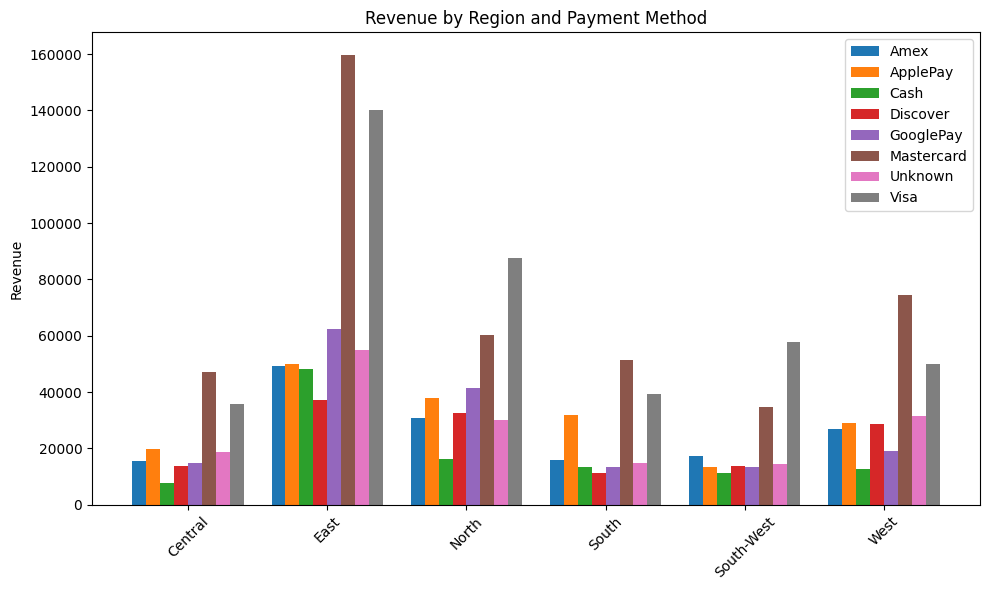

In [11]:
pm_region_pivot = pm_region_summary.pivot(
    index="Region",
    columns="PaymentMethod",
    values="Revenue"
).fillna(0)

display(pm_region_pivot)

plt.figure(figsize=(10, 6))

regions = pm_region_pivot.index
methods = pm_region_pivot.columns
x = range(len(regions))
bar_width = 0.8 / len(methods)

for i, method in enumerate(methods):
    plt.bar(
        [xi + i * bar_width for xi in x],
        pm_region_pivot[method],
        width=bar_width,
        label=method
    )

plt.xticks([xi + bar_width*(len(methods)-1)/2 for xi in x],
           regions, rotation=45)
plt.ylabel("Revenue")
plt.title("Revenue by Region and Payment Method")
plt.legend()
plt.tight_layout()
plt.show()

# ## 8. Drilldown: Store × Payment Method

PaymentMethod,Amex,ApplePay,Cash,Discover,GooglePay,Mastercard,Unknown,Visa
StoreID,,,,,,,,
401,37009.92,56347.74,24261.36,34417.93,49841.51,118838.60,29243.28,78800.06
402,33573.02,43142.86,25289.14,42322.87,36408.42,96535.61,48035.26,107892.47
403,43274.36,38097.94,27539.55,28039.13,38250.76,103115.29,35380.36,107404.66
404,42284.58,44034.95,32425.92,32186.51,39588.61,109322.37,52209.06,116314.59


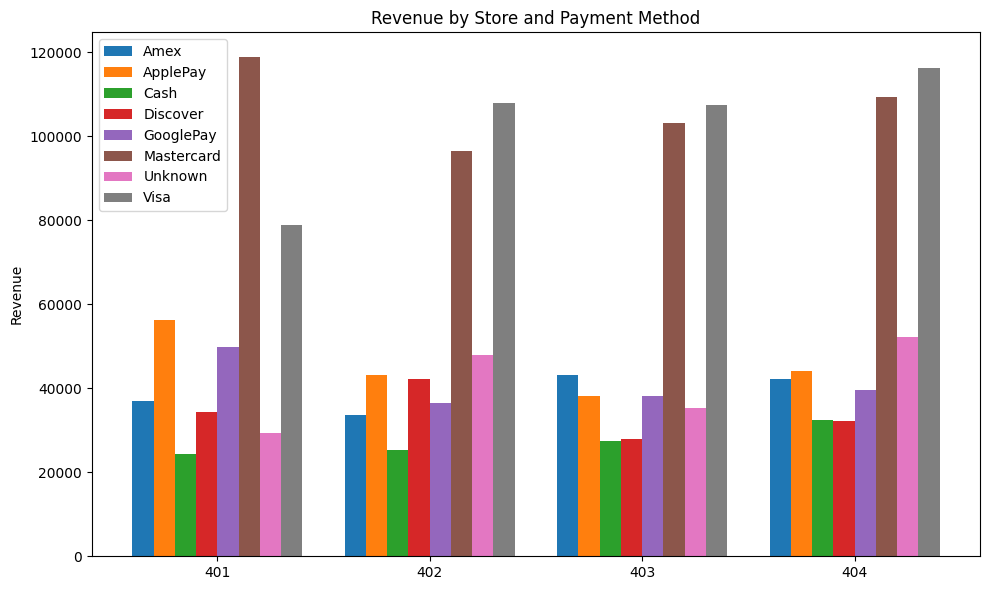

In [12]:
store_payment = (
    df.groupby(["StoreID", "PaymentMethod"])
      .agg(Revenue=("SaleAmount", "sum"))
      .reset_index()
)

store_pivot = store_payment.pivot(
    index="StoreID",
    columns="PaymentMethod",
    values="Revenue"
).fillna(0)

display(store_pivot)

plt.figure(figsize=(10, 6))

stores = store_pivot.index
methods = store_pivot.columns
x = range(len(stores))
bar_width = 0.8 / len(methods)

for i, method in enumerate(methods):
    plt.bar(
        [xi + i * bar_width for xi in x],
        store_pivot[method],
        width=bar_width,
        label=method
    )

plt.xticks([xi + bar_width*(len(methods)-1)/2 for xi in x],
           stores, rotation=0)
plt.ylabel("Revenue")
plt.title("Revenue by Store and Payment Method")
plt.legend()
plt.tight_layout()
plt.show()

## 9. Recommended Business Strategy

### 1. Strengthen support for Mastercard & Visa
- These two methods generate nearly half of all revenue and see the highest volume.  Recommend joinig merchant funded offer programs and card linked offers.  Consider further targetting within regions where there is the most revenue (i.e. East).  

### 2. Expand digital payment options
- ApplePay + GooglePay represent ~20% of revenue and show potential for stronger adoption.  It's likely many consumers will continue to adopt mobile wallets to use with current credit cards.  The availability of digital payments should be uniform across all stores and regions.

### 3. Further research into the “Unknown” payment method
- It represents a meaningful percentage of sales and should be researched into more deeply as to what was the payment method(s).  This likely should have been done in the cleaning stage.    

### 4. Leverage regional insights
- Promote strongly in the **East**, the highest-revenue region.

### 5. Tailor category strategies
- **Electronics & Office**: Promote credit-card-based reward programs around these two areas.  Additinally, can attempt to stimulate additional sales in other categories with linked offers.  

## 10. BI Ethics & AI Reflection

### 1. Is the data being used responsibly?
Yes. The dataset includes only transaction-level and product-level data. No personally identifiable or sensitive information is used.

### 2. Could the analysis reinforce biases?
Potentially. Payment preference can correlate with socioeconomic or regional factors. Placing too much emphasis on “high-value” payment types might unintentionally disadvantage users who rely on cash or alternative payment methods.  It could further not anticipate changes in consumer spending habits and methods.  

### 3. Are decisions being made based on incomplete or unverified data?
Yes — the “Unknown” payment method accounts for a significant percentage of revenue. This likely reflects missing or misclassified data and could distort conclusions if not addressed.  Better cleaning of data or, more ideally, better classification of data. 

### 4. How can insights be applied responsibly?
- Improve digital payment support without reducing traditional options.
- Fix data quality issues related to “Unknown” classification.
- Avoid assuming that all regions or demographics share the same payment preferences.
- Use insights to improve operations, not exclude customer groups.